# Pubmed Papers: Jargon Analysis
### Regression  
#### *Attempt to model the relationship between the proportion and frequency of jargon words with the target variable: citations.* 

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


#modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import f_regression, SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

import re
from nltk.tokenize import WhitespaceTokenizer

import warnings
warnings.filterwarnings('ignore')

In [187]:
filename =  '../data/pubmed_vectorized_jargon.csv'

In [188]:
df = pd.read_csv(filename).set_index('pmid')

In [189]:
df.head()

,citations,fulltext,A/B testing,accuracy,action,activation function,active learning,AdaGrad,agent,agglomerative clustering,...,user matrix,validation,validation set,vanishing gradient problem,Wasserstein loss,weight,Weighted Alternating Least Squares (WALS),wide model,width,total_jargon_count
pmid,,,,,,,,,,,,,,,,,,,,,
22627698,35,extracting biological information computationa...,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,11
22952238,4,uncovering transcription factor modules using ...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
22944687,19,understanding substrate specificity convention...,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
22075226,12,membrane protein structural bioinformatics des...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
23012584,10,future medical diagnostics: large digitized da...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [190]:
df.isnull().sum()

citations                                    0
fulltext                                     0
A/B testing                                  0
accuracy                                     0
action                                       0
                                            ..
weight                                       0
Weighted Alternating Least Squares (WALS)    0
wide model                                   0
width                                        0
total_jargon_count                           0
Length: 415, dtype: int64

In [191]:
X = df.drop(columns = ['citations', 'fulltext'])
y = df['citations']

#### Look at Phrase Frequency in the Corpus

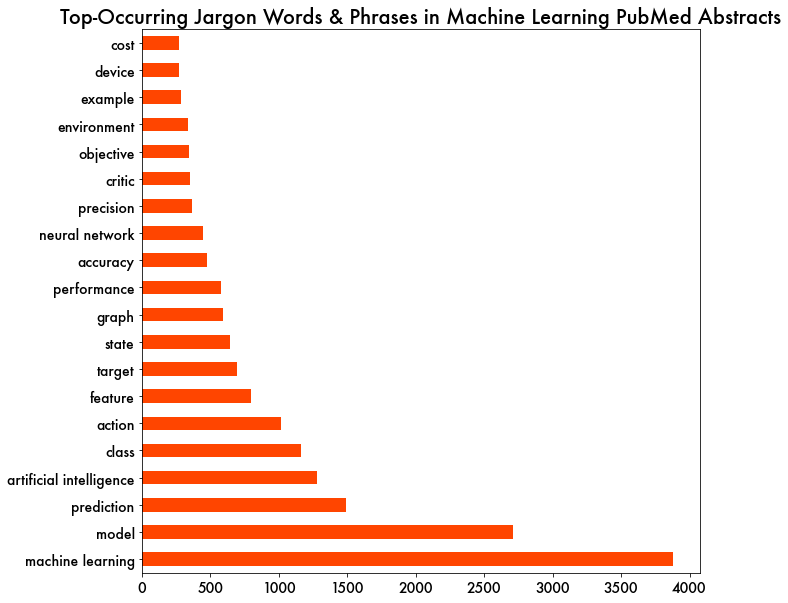

In [170]:
# plot top occurring words/phrases

#remove the total count for the plot
jargon_X = X.drop(columns='total_jargon_count')
plt.figure(figsize = (10,10))
jargon_X.sum().sort_values(ascending = False).head(20).plot(kind='barh', color='orangered');
figurefont = {'fontname' : 'Futura'}
plt.xticks(**figurefont, fontsize = 14);
plt.yticks(**figurefont, fontsize = 14);
plt.title('Top-Occurring Jargon Words & Phrases in Machine Learning PubMed Abstracts',**figurefont, fontsize = 20);
plt.savefig('../figures/pubmed_top_occurring_jargon.jpg',  bbox_inches = "tight")



### Investigation I: Effect of Proportion of Jargon on Number of Citations
#### *Attempt to replicate the findings in Martinez & Mammola*

In [171]:
df['total_jargon_count'].head()

pmid
22627698    11
22952238     3
22944687     7
22075226     2
23012584     1
Name: total_jargon_count, dtype: int64

In [172]:
#read in preprocessed abstracts to get total word count
pubmed = pd.read_csv('../data/pubmed_nltk_stemmed_preproc.csv').set_index('pmid')

In [173]:
#remove punctuation characters 
pubmed['fulltext'] = pubmed['fulltext'].replace("[''·,\.!?'-]",'',regex=True)
#remove brackets surrounding the text
pubmed['fulltext'] = pubmed['fulltext'].map(lambda x: x.replace("[",""))
pubmed['fulltext'] = pubmed['fulltext'].map(lambda x: x.replace("]",""))

In [174]:
#tokenize text into lists to get word count
w_tokenizer = WhitespaceTokenizer()
pubmed['fulltext'] = pubmed['fulltext'].apply(lambda x: w_tokenizer.tokenize(x))

In [180]:
# calculate word count, jargon count, and jargon proportion 
word_count = pubmed['fulltext'].apply(lambda x: len(x))
jargon_count = df['total_jargon_count']
jargon_prop = (jargon_count/word_count)

#Create new dataframe with jargon prop and citations
prop = pd.DataFrame()
prop['jargon_prop'] = pd.Series(jargon_prop)
prop['citations'] = df['citations']

In [181]:
# calculate correlation
stats.pearsonr(prop['citations'],prop['jargon_prop'])

(0.033106816530424056, 0.07936863784555157)

The proportion of machine learning jargon is not correlated with the number of citations. This is a failure to replicate the findings in Martinez & Mammola.

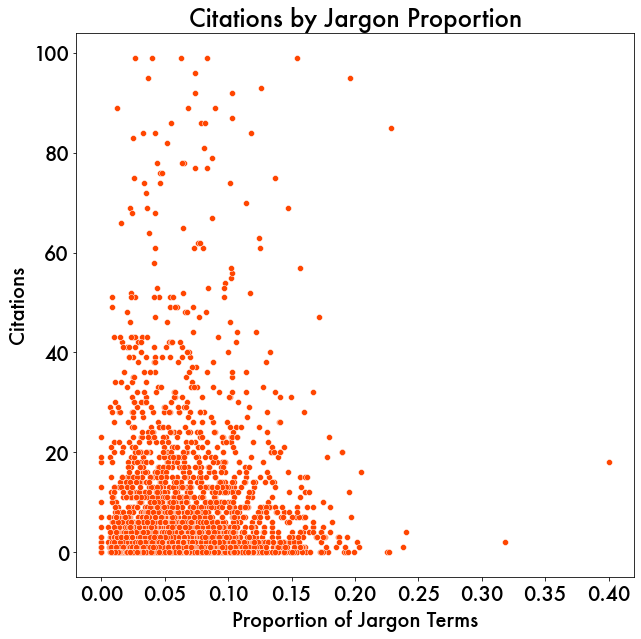

In [177]:
plt.figure(figsize = (10, 10));
sns.scatterplot(data=prop, x='jargon_prop', y='citations', color='orangered');
figurefont = {'fontname' : 'Futura'};
plt.title('Citations by Jargon Proportion', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Proportion of Jargon Terms',**figurefont, fontsize = 20);
plt.ylabel('Citations',**figurefont, fontsize = 20);
plt.savefig('../figures/pubmed_citations_jargon_prop_scatterplot.jpg',  bbox_inches = "tight")

### Investigation II: Effect of Jargon Quantity on Number of Citations

In [137]:
stats.pearsonr(df['citations'],df['total_jargon_count'] )

(0.027498692778366057, 0.14510049541405487)

Given the lack of correlation between the total jargon count and the number of citations, I will see if any of the specific jargon terms (collectively or separately) account for some of the variance in the number of citations.

#### StatsModels

In [153]:
X_new = SelectKBest(chi2, k=100).fit_transform(X, y)
X_new.shape

(2809, 100)

In [154]:
X_sm = sm.add_constant(X_new, prepend=True)

In [155]:
#train-test split 
X_train_sm, X_test_sm, y_train_sm, y_test_sm=train_test_split(X_sm,
                                                 y,
                                                 test_size=.2,
                                                 random_state=42)

In [156]:
results = sm.OLS(y_train_sm, X_train_sm).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              citations   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     2.293
Date:                Wed, 12 May 2021   Prob (F-statistic):           2.40e-11
Time:                        14:13:59   Log-Likelihood:                -9029.1
No. Observations:                2247   AIC:                         1.826e+04
Df Residuals:                    2146   BIC:                         1.884e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1756      0.598     13.681      0.000       7.004       9.347
x1             2.3686      0.949      2.496      0.013       0.508       4.229
x2             3.4544      0.777      4.444      0.000       1.930       4.979
x3             9.4013     10.037      0.937      0.349     -10.282      29.085
x4             7.4660      4.793      1.558      0.119      -1.934      16.866
x5             3.4395      1.195      2.878      0.004       1.096       5.783
x6             2.9298      0.793      3.697      0.000       1.376       4.484
x7             4.9210      2.394      2.055      0.040       0.226       9.616
x8             1.7643      3.633      0.486      0.627      -5.360       8.889
x9             0.0102      7.341      0.001      0.999     -14.386      14.407
x10            3.5731      1.627      2.196      0.028       0.382       6.764
x11           57.7275     15.607      3.699      0.000      27.120      88.335
x12            4.1696      0.794      5.253      0.000       2.613       5.726
x13            3.3999      1.308      2.600      0.009       0.835       5.965
x14            2.3185      2.287      1.014      0.311      -2.167       6.804
x15            6.1956      2.935      2.111      0.035       0.441      11.950
x16            3.2183      1.104      2.916      0.004       1.054       5.383
x17            3.6321      1.013      3.584      0.000       1.645       5.619
x18            4.6962      1.304      3.602      0.000       2.140       7.253
x19            5.4823      1.724      3.179      0.001       2.101       8.864
x20            7.5599      2.002      3.775      0.000       3.633      11.487
x21            2.8749      0.935      3.076      0.002       1.042       4.708
x22           23.5968      8.166      2.890      0.004       7.584      39.610
x23           10.9336      2.662      4.108      0.000       5.714      16.153
x24           18.2985      6.561      2.789      0.005       5.432      31.165
x25            3.0396      1.581      1.922      0.055      -0.061       6.141
x26            3.5000      0.927      3.774      0.000       1.681       5.319
x27            4.4379      2.506      1.771      0.077      -0.477       9.353
x28          -12.6866     14.476     -0.876      0.381     -41.075      15.702
x29            2.0654      1.111      1.859      0.063      -0.113       4.244
x30            4.4300      0.842      5.263      0.000       2.779       6.081
x31            5.3436      1.999      2.673      0.008       1.424       9.264
x32           32.9450     10.082      3.268      0.001      13.174      52.717
x33           10.8561      2.614      4.153      0.000       5.729      15.983
x34            1.0647      3.892      0.274      0.784      -6.568       8.697
x35            5.0806      3.580      1.419      0.156      -1.941      12.102
x3

Very low R2. This feels like a dead end, but I will explore the other regressors in sklearn to see if there is any sign of life. 

#### sklearn

In [192]:
#train-test split 
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 random_state=42)

In [158]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [159]:
train_score = linreg.score(X_train, y_train)
test_score = linreg.score(X_test, y_test)
cv_score = cross_val_score(linreg, X_train, y_train).mean()
print(train_score, test_score, cv_score)

0.1001694881137769 -6.580819492417445e+19 -4.5225530269651395e+19


Only 0.1 R2 for the training data - it appears that none of these jargon terms are predictive of the number of citations; will try regularization, as it's still overfit at 0.1! 

In [193]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [163]:
# Set up a list of Lasso alphas to check.
l_alphas = np.linspace(-3,0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=5_000)

# Fit model using best lasso alpha!
lasso_cv.fit(Z_train, y_train)

train_score = lasso_cv.score(Z_train, y_train)
test_score = lasso_cv.score(Z_test, y_test)
cv_score = cross_val_score(lasso_cv, Z_train, y_train).mean()
print(train_score, test_score, cv_score)

0.1001720289971817 -0.13368730296895492 -14863991.480630387


Throwing the kitchen sink at this just to put a pin in it. 

In [194]:
model_list = [
    LinearRegression(),
    DecisionTreeRegressor(),
    BaggingRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    SVR(),
    MLPRegressor()
]

results_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj
   
    #fit the model
    model.fit(X_train, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(Z_train, y_train)
    results_dict['test_score'] = model.score(Z_test, y_test)
    results_dict['cv_score'] = cross_val_score(model, Z_train, y_train, cv = 5).mean()
    results_dict['train_RMSE'] = np.sqrt(mean_squared_error(y_train, model.predict(Z_train)))
    results_dict['test_RMSE'] = np.sqrt(mean_squared_error(y_test, model.predict(Z_test))) 
    
    #add the dictionary to the list
    results_list.append(results_dict)

In [195]:
results = pd.DataFrame(results_list)
results

,model_name,train_score,test_score,cv_score,train_RMSE,test_RMSE
0,LinearRegression(),-1.203099e+24,-1.495058e+24,-1.661066e+27,1.552674e+13,1.741273e+13
1,DecisionTreeRegressor(),-2.649135e+00,-2.918377e+00,-9.048979e-01,2.704111e+01,2.818974e+01
2,BaggingRegressor(),-5.804909e-01,-1.054197e+00,-2.047910e-01,1.779613e+01,2.041076e+01
3,RandomForestRegressor(),-4.505511e-01,-8.704999e-01,-1.444079e-01,1.704889e+01,1.947677e+01
4,AdaBoostRegressor(),-1.058666e+00,-1.056006e+00,-1.125183e+00,2.031059e+01,2.041974e+01
5,SVR(),-1.507664e-01,-1.825535e-01,-1.274448e-01,1.518529e+01,1.548633e+01
6,MLPRegressor(),-1.878661e+01,-2.709022e+01,-6.580365e+00,6.296733e+01,7.547717e+01


These are very poor results. None of these words account for the variance in the target variable. 